In [1]:
import numpy as np
import pandas as pd
import random
from datetime import timedelta, datetime
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
import random
from datetime import timedelta, datetime


from tqdm.auto import tqdm

# Store-level demand multipliers
store_ids = [f"store_{i}" for i in range(20)]
store_factors = {sid: round(random.uniform(0.5, 2.0), 2) for sid in store_ids}
MAX_PRODUCTS = 100
seasonalities = {
    pid: random.choice([False, 30, 30 * 4, 30 * 8, 365]) for pid in range(MAX_PRODUCTS)
}
volumes = {pid: random.choice([5, 20, 100]) for pid in range(MAX_PRODUCTS)}
zero_sales_ratio = {
    pid: random.choice([round(0.1 * i, 1) for i in range(0, 10)])
    for pid in range(MAX_PRODUCTS)
}
n_days = random.randint(365, 365 * 4)


def generate_sklearn_sales_data_v2(
    num_days=30,
    num_products=20,
    num_stores=5,
    start_date="2020-01-01",
    seed=None,
):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    if num_stores > len(store_ids):
        num_stores = len(store_ids)

    # Promo logic: 10% of days are promos
    def is_promo():
        return np.random.rand() < 0.1

    # volume_scale = {"low": 5, "medium": 20, "high": 100}[volume_level]

    start = datetime.strptime(start_date, "%Y-%m-%d")

    # Product categorical features
    categorical_choices = {
        "color": ["red", "blue", "green", "black", "white"],
        "size": ["S", "M", "L", "XL"],
        "category": ["shoes", "dress", "suit", "socks", "bag", "costume"],
        "subcategory": ["A", "B", "C", "D", "E", "F"],
    }
    # Example categorical behavior maps
    category_factor = {
        "shoes": 1.2,
        "dress": 1.4,
        "suit": 1.0,
        "socks": 0.8,
        "bag": 0.8,
        "costume": 0.5,
    }
    subcategory_factor = {"A": 1.2, "B": 1.5, "C": 1, "D": 0.8, "E": 0.6, "F": 0.7}
    size_factor = {"S": 0.8, "M": 1.0, "L": 1.1, "XL": 1.2}
    color_bias = {"red": 1.0, "blue": 1.0, "green": 0.95, "black": 1.05, "white": 1.0}

    all_rows = []
    with tqdm(range(num_products)) as pbar:
        for pid in pbar:
            # product_id = base64.standard_b64encode(f"{time.time()}".encode()).decode()
            product_id = f"product_{pid}"
            pbar.set_description(product_id)
            product_cats = {k: random.choice(v) for k, v in categorical_choices.items()}
            volume_scale = volumes[pid]

            # generate base features per product
            X, y = make_regression(n_samples=num_days, n_features=3, noise=0.1)
            base_price = np.clip(X[:, 0] * 10 + 50, 5, 150)
            base_stock = np.clip(X[:, 1] * 100 + 500, 0, 2000)
            base_discount = np.clip(np.abs(X[:, 2] * 0.05), 0, 0.3)

            cat_factor = (
                category_factor[product_cats["category"]]
                * size_factor[product_cats["size"]]
                * color_bias[product_cats["color"]]
                * subcategory_factor[product_cats["subcategory"]]
            )

            for store_id in random.choices(store_ids, k=num_stores):
                store_factor = store_factors[store_id]

                for i in range(num_days):
                    date = start + timedelta(days=i)
                    promo = is_promo()

                    # Seasonality
                    seasonal_factor = 1.0
                    seasonality = seasonalities[pid]
                    if seasonality:
                        seasonal_factor += np.sin(
                            2 * np.pi * i / seasonality
                            + np.random.uniform(0, 2 * np.pi)
                        )

                    # Demand scaling
                    demand_multiplier = (
                        seasonal_factor
                        * store_factor
                        * cat_factor
                        * (round(random.uniform(1.5, 2.0), 2) if promo else 1.0)
                    )

                    if np.random.rand() < zero_sales_ratio[pid]:
                        sales_qty = 0
                    else:
                        raw_sales = abs(y[i]) * 0.1 * demand_multiplier * volume_scale
                        sales_qty = int(np.clip(raw_sales, 0, None))

                    row = {
                        "date": date,
                        "store_id": store_id,
                        "product_id": product_id,
                        "sales_qty": sales_qty,
                        "price": round(base_price[i], 2),
                        "stock": int(base_stock[i]),
                        "discount": round(base_discount[i], 2),
                        "is_promo_day": promo,
                        **product_cats,
                    }
                    all_rows.append(row)
    df = pd.DataFrame(all_rows).sort_values("date")
    return df

  0%|          | 0/10 [00:00<?, ?it/s]

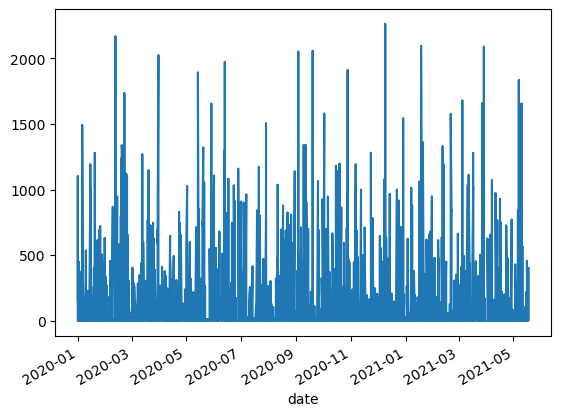

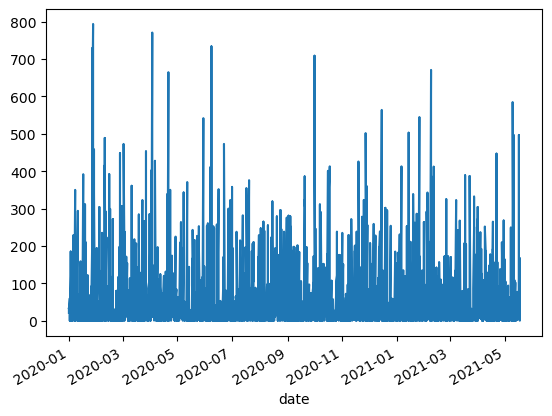

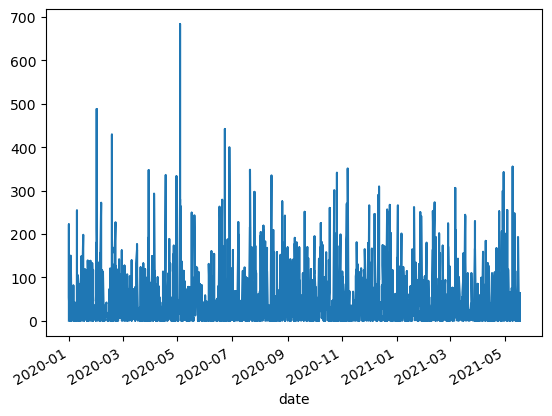

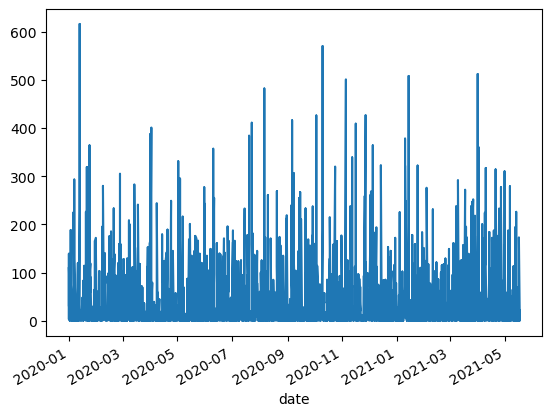

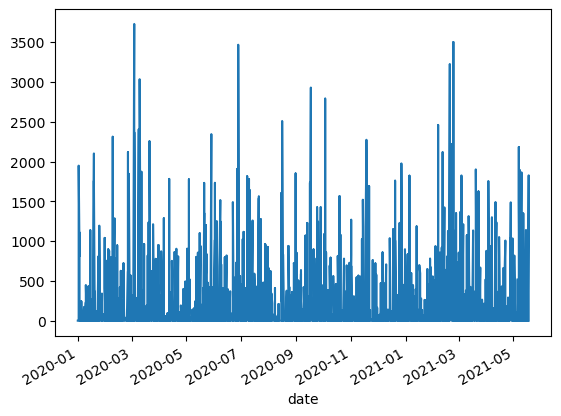

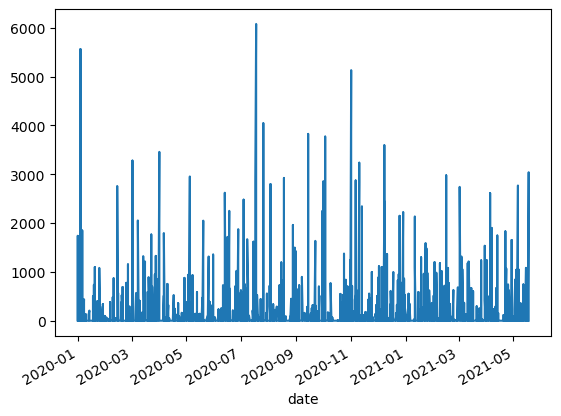

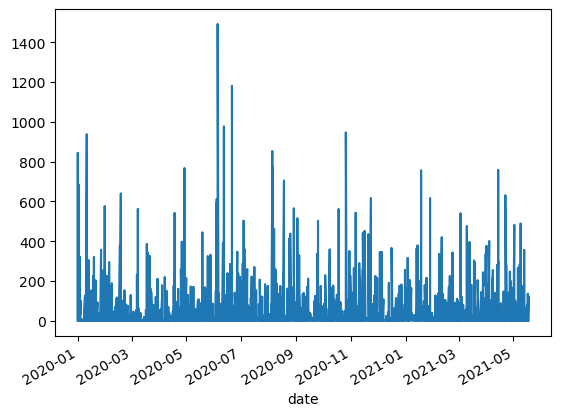

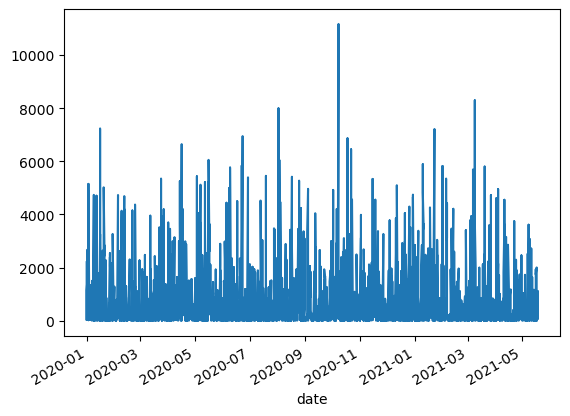

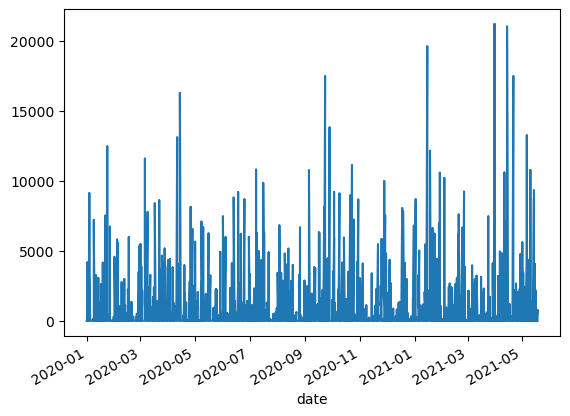

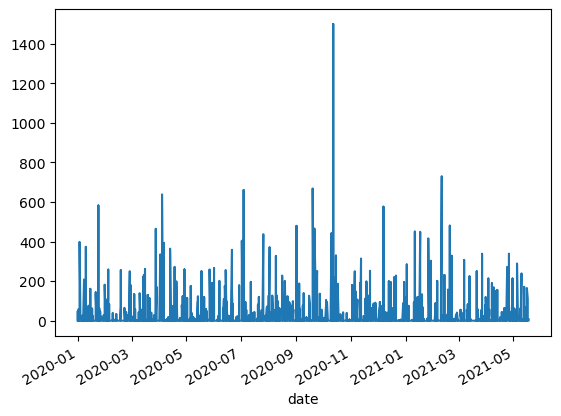

In [2]:
df = generate_sklearn_sales_data_v2(
    num_days=n_days,
    num_products=10,
    seed=42,
)

for label, group in df.groupby("product_id"):
    group.set_index("date")["sales_qty"].plot()
    plt.show()

In [3]:
sklearnFakedata = generate_sklearn_sales_data_v2(
    num_days=365 * 4,
    num_products=MAX_PRODUCTS,
    num_stores=20,
    seed=42,
)

sklearnFakedata.to_csv("sklearnFakeData_v2.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

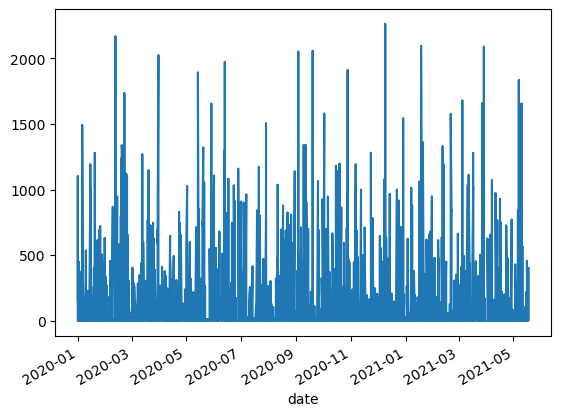

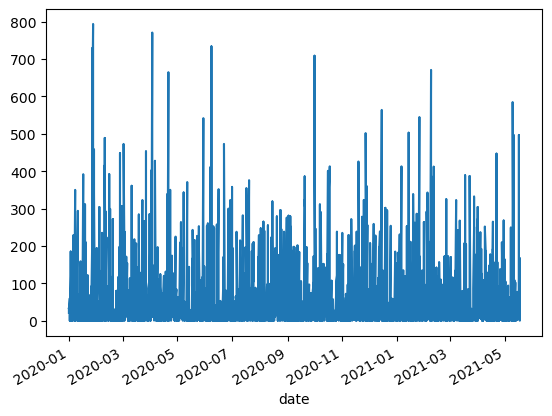

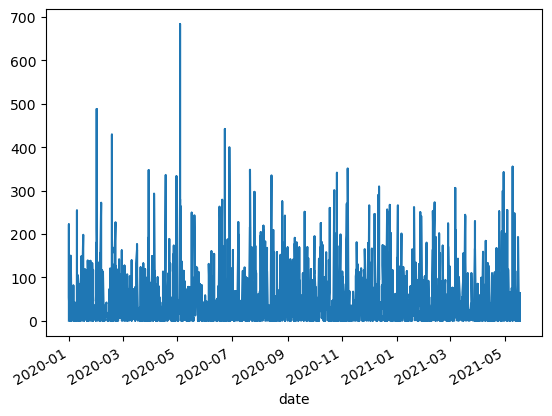

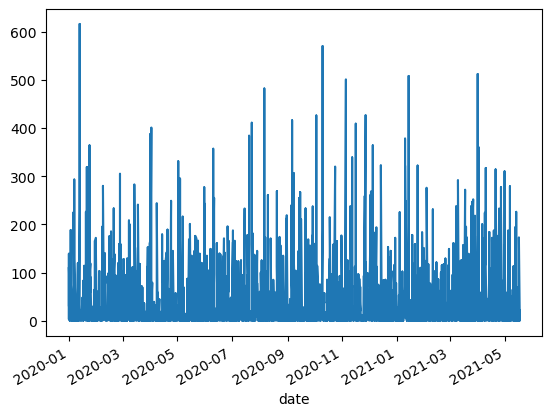

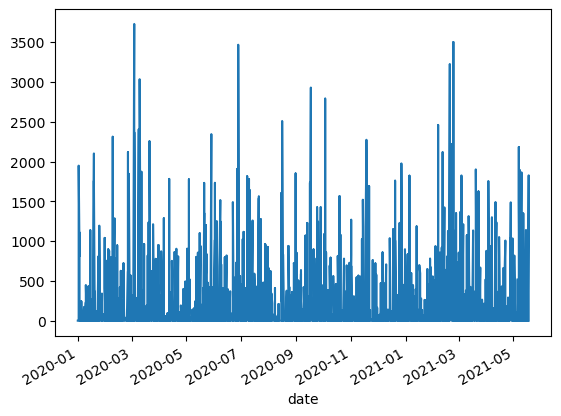

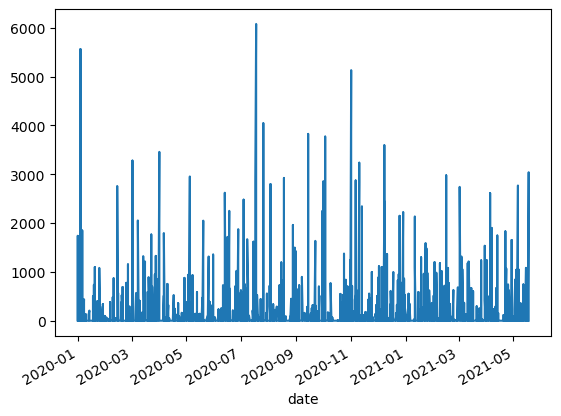

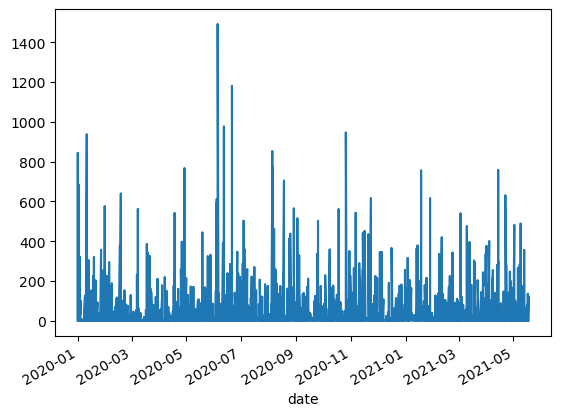

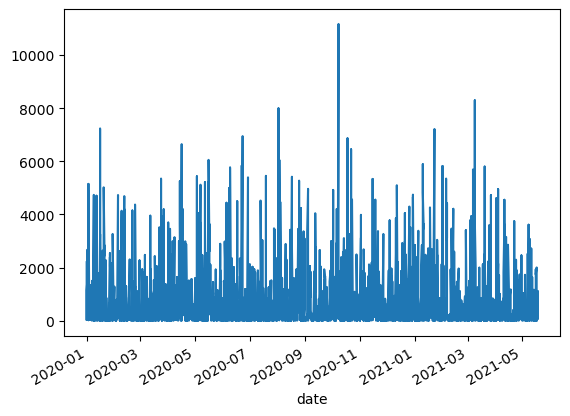

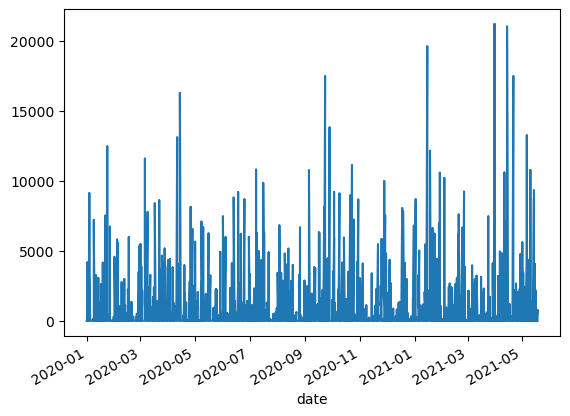

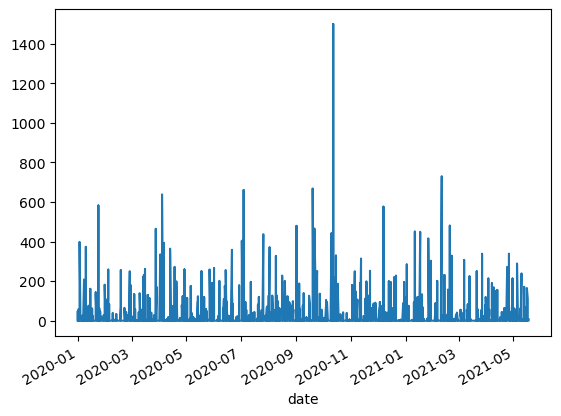

In [4]:
for idx, (label, group) in enumerate(df.groupby("product_id")):
    group.set_index("date")["sales_qty"].plot()
    plt.show()
    if idx > 10:
        break

In [5]:
{c: sklearnFakedata[c].nunique() for c in sklearnFakedata.columns}

{'date': 1460,
 'store_id': 20,
 'product_id': 100,
 'sales_qty': 11123,
 'price': 6003,
 'stock': 740,
 'discount': 24,
 'is_promo_day': 2,
 'color': 5,
 'size': 4,
 'category': 6,
 'subcategory': 6}